In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier

# **Step 1**

## OLS on PD

In [ ]:
data = pd.read_excel('../dataproject2024.xlsx')
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [ ]:
# Scale continuous variables to have a meaningful comparison of the coefficients
continuous_features = ['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration','Monthly payment']
categorical_features = ['Down payment', 'Credit event', 'Married', 'Homeowner']

model = LinearRegression()

# Scale continuous features, include categorical features, drop the remaining columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuous_features),
    ('cat','passthrough',categorical_features)
],
remainder='drop')

# Fit a linear regression with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        
    ('regression', model)    
])


y = data['PD']

# Split data between test and train
X_train, X_test, y_train, y_test = train_test_split(data,y)

# Fit the regressor
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Compute the RMSE
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"""For the OLS surrogate model:
      - The RMSE is {rmse} 
      - The r2 score is {r2}""")

For the OLS surrogate model:
      - The RMSE is 0.16265365060693965 
      - The r2 score is 0.443254405436467


/var/folders/k7/yjlj1gk15bj1gjrxppqlsy9r0000gn/T/ipykernel_4101/1028221056.py:15: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(x=ranked_coefficients, y=ranked_features, palette=colors, ci=None)


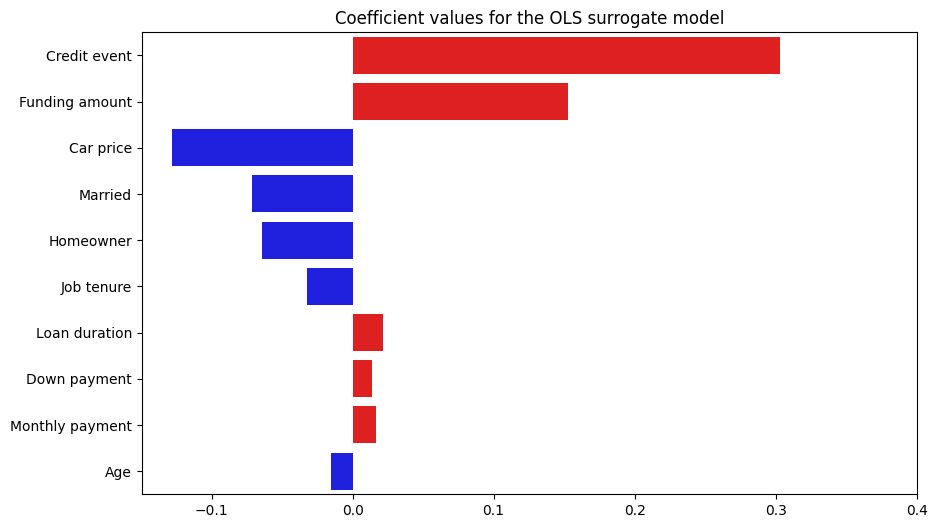

In [ ]:
# Retrieve the coefficient values and feature names
coefficients = pipeline.named_steps['regression'].coef_
features = continuous_features + categorical_features

# Sort features by absolute coefficient values
features_and_coeff = zip(features, coefficients)
features_and_coeff_ranked = sorted(features_and_coeff, key=lambda x: abs(x[1]), reverse=True)
ranked_features, ranked_coefficients = zip(*features_and_coeff_ranked)

# Assign colors based on coefficient sign
colors = ['red' if coeff > 0 else 'blue' for coeff in ranked_coefficients]

# Plot the coefficient values for each feature
plt.figure(figsize=(10, 6))
sns.barplot(x=ranked_coefficients, y=ranked_features, palette=colors, ci=None)
plt.title("Coefficient values for the OLS surrogate model")
plt.xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4])

# Display the plot
plt.show()


## Decision tree

In [ ]:
data = pd.read_excel('../dataproject2024.xlsx')
data.tail()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0
7429,7430,5,47,15900,17764,0,96,0.135000,0,1,0,0,0,0.150553,0


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

data = pd.read_excel('../dataproject2024.xlsx')
y = data['PD']
X = data.drop(columns=['ID', 'Default (y)', 'Pred_default (y_hat)', 'PD', 'Group'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

decision_tree = DecisionTreeRegressor(max_depth=2, criterion='squared_error')

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
features = decision_tree.feature_names_in_
print(f"""For the decision tree surrogate model:
      - The RMSE is {rmse} 
      - The r2 score is {r2}""")

For the decision tree surrogate model:
      - The RMSE is 0.18942154950144657 
      - The r2 score is 0.21719107227748136


In [ ]:
param_grid = {'min_impurity_decrease':[0.001, 0.0015, 0.002, 0.0025, 0.0027, 0.0028, 0.003]}
X_train, X_test, y_train, y_test = train_test_split(X, y)
decision_tree = DecisionTreeRegressor(max_depth=3, criterion='squared_error')
grid_search = GridSearchCV(decision_tree, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_decision_tree = grid_search.best_estimator_

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV] END ........................min_impurity_decrease=0.001; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.001; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.001; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.001; total time=   0.0s
[CV] END .......................min_impurity_decrease=0.0015; total time=   0.0s
[CV] END .......................min_impurity_decrease=0.0015; total time=   0.0s
[CV] END .......................min_impurity_decrease=0.0015; total time=   0.0s
[CV] END .......................min_impurity_decrease=0.0015; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.002; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.002; total time=   0.0s
[CV] END ........................min_impurity_decrease=0.002; total time=   0.0s
[CV] END ........................min_impurity_dec

In [ ]:
best_decision_tree

DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.001)

In [ ]:
y_pred = best_decision_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"""For the decision tree surrogate model:
      - The RMSE is {rmse} 
      - The r2 score is {r2}""")

For the decision tree surrogate model:
      - The RMSE is 0.17548538429457997 
      - The r2 score is 0.3290036897069857


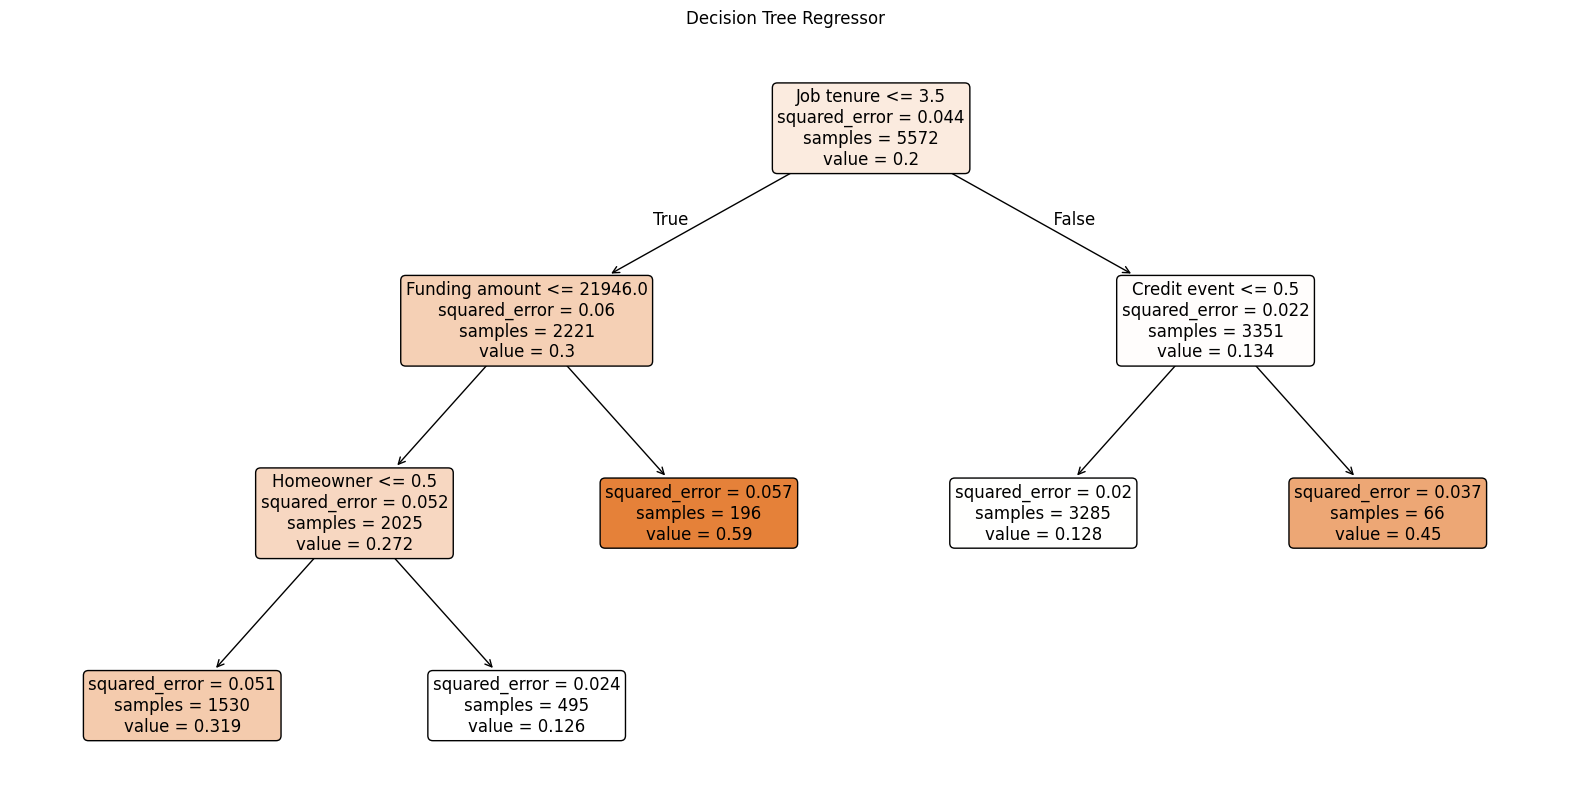

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(best_decision_tree, 
               feature_names=best_decision_tree.feature_names_in_, 
               filled=True, 
               rounded=True, 
               fontsize=12)
plt.title("Decision Tree Regressor")
plt.show()

# **Step 2**

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_excel('../dataproject2024.xlsx')
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [ ]:
percentage_of_default = data['Pred_default (y_hat)'].sum() / data.shape[0]
print(f"The percentage of default in the dataset is {percentage_of_default:.2%}")

The percentage of default in the dataset is 11.62%


In [ ]:
X = data.drop(columns=['ID', 'Default (y)', 'Pred_default (y_hat)','PD','Group'])
y = data['Default (y)']
X.head()

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner
0,34,55,4875,3087,0,36,0.047895,0,1,1
1,5,29,13000,13000,0,60,0.091667,0,0,0
2,14,38,17190,14190,0,60,0.088235,0,0,0
3,16,37,22773,23568,0,48,0.110084,0,1,1
4,1,61,7700,8526,0,48,0.123404,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100,150,200],
    'max_depth' : [5,10,20],
    'min_samples_split': [3, 5, 10], 
    'min_samples_leaf': [2, 3, 5]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=4, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
clf_best = grid_search.best_estimator_

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf

In [ ]:
y_pred_probs = clf_best.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_probs)
print(f"The AUC of the optimized model is {auc}")

The AUC of the optimized model is 0.7775339285220708


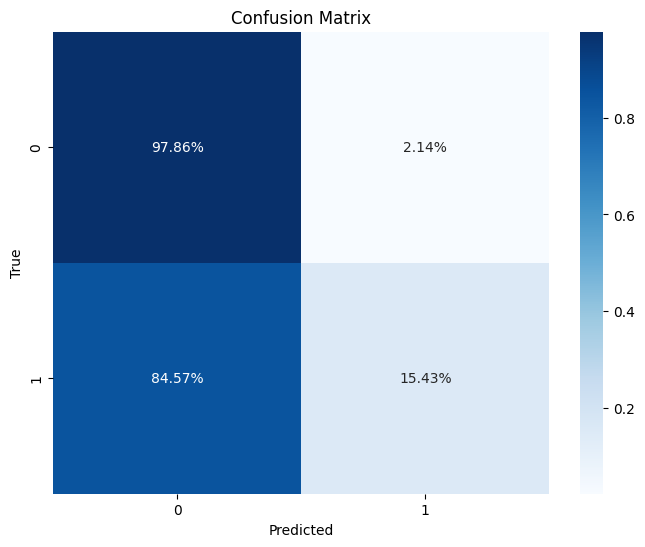

In [ ]:
y_pred = clf_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues")  # Corrected fmt argument
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
y_pred = clf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the model without moving the threshold is {accuracy}")

The accuracy of the model without moving the threshold is 0.817545748116254


In [ ]:
updated_data = pd.read_excel("../dataproject2024.xlsx")
data_for_prediction = updated_data.drop(columns=['ID', 'Default (y)', 'Pred_default (y_hat)','PD','Group'])
updated_data['clf_prediction_proba'] = clf_best.predict_proba(data_for_prediction)[:,1]
updated_data

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group,clf_prediction_proba
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1,0.061399
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0,0.260478
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0,0.113510
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1,0.045664
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0,0.398638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0,0.411060
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0,0.211315
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0,0.386767
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0,0.184368


Text(0.5, 1.0, 'Predicted probability of default vs actual default value')

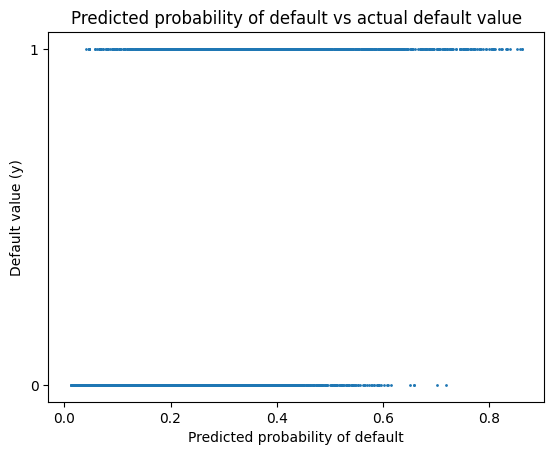

In [ ]:
plt.scatter(updated_data['clf_prediction_proba'],updated_data['Default (y)'],s=1)
plt.xlabel('Predicted probability of default')
plt.ylabel('Default value (y)')
plt.yticks([0,1])
plt.title("Predicted probability of default vs actual default value")

In [ ]:
preds = updated_data['clf_prediction_proba']
labels = updated_data['Default (y)']

precision, recall, thresholds = precision_recall_curve(labels, preds)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))

Best Threshold=0.293363, F-Score=0.636


In [ ]:
updated_data['clf_prediction_class'] = (updated_data['clf_prediction_proba']>best_threshold).astype(int)
updated_data

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group,clf_prediction_proba,clf_prediction_class
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1,0.061399,0
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0,0.260478,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0,0.113510,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1,0.045664,0
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0,0.398638,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0,0.411060,1
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0,0.211315,0
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0,0.386767,1
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0,0.184368,0


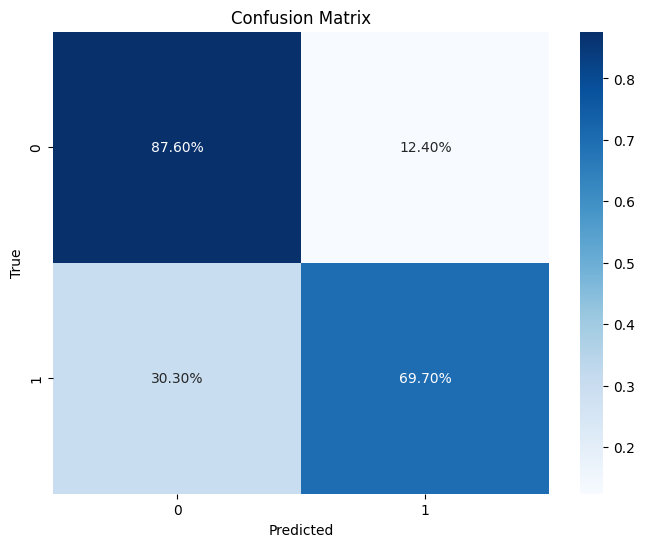

In [ ]:
cm = confusion_matrix(updated_data['Default (y)'],updated_data['clf_prediction_class'])
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues")  # Corrected fmt argument
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(f"The accuracy of this new model is {accuracy_score(updated_data['Default (y)'],updated_data['clf_prediction_class'])}")

The accuracy of this new model is 0.8402422611036339


# **Step 3**